# 基于DFF的图像子区域可解释性分析

对单张图像，进行Deep Feature Factorization可解释性分析，展示Concept Discovery概念发现图。

2022-9-19

## 参考阅读

代码库 pytorch-grad-cam：https://github.com/jacobgil/pytorch-grad-cam

博客 Deep Feature Factorizations for better model explainability：https://jacobgil.github.io/pytorch-gradcam-book/Deep%20Feature%20Factorizations.html

论文 Deep Feature Factorization For Concept Discovery：https://arxiv.org/abs/1806.10206

## 导入工具包

In [59]:
import warnings
warnings.filterwarnings('ignore')
import requests

from PIL import Image
import numpy as np
import pandas as pd
import cv2
import json

import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image
from pytorch_grad_cam import GradCAM
from torchvision.models import resnet50
from COME15KClassDataset import set_data_loader
import torch

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('device', device)

device cpu


## 预处理函数

In [161]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [162]:
def get_image_from_path(img_path):
    '''
    输入图像文件路径，输出 图像array、归一化图像array、预处理后的tensor
    '''

    img = Image.open(img_path)
    # img = img.resize((256,256))
    img = np.array(img)
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [163]:
def create_labels(concept_scores, top_k=2):
    """ Create a list with the category names of the top scoring categories"""
    
    labels = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}
    
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]    
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{labels[category].split(',')[0]}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk

## 载入模型

In [164]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
model_path = 'models/2023-09-25-17:12_max_epoch_50/'
model_name = 'retrain_COME15K_checkpoint-best-easy-0.736-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# init model
model_and_weight_path = model_path + model_name
model = torch.load(model_and_weight_path)
model = model.eval().to(device)
model

ShuffleNetV2_Plus(
  (first_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
    (2): HS()
  )
  (features): Sequential(
    (0): Shufflenet(
      (branch_main): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (5): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
     

## 载入测试图像

In [165]:
test_dataset_loader_easy = set_data_loader(dataset_attr_word="test_easy", batch_size=1, size=512, shuffle=False,
                                           transforms_compose=None, dataset_dir = 'data/SOD-SemanticDataset-OriginalSize')
data_path = test_dataset_loader_easy.dataset.data_path
img_paths = test_dataset_loader_easy.dataset.images
img_lables = test_dataset_loader_easy.dataset.labels

In [166]:
img_paths_final = [data_path + img_name for img_name in img_paths]
img_path = img_paths_final[2]
img_pil = Image.open(img_path)

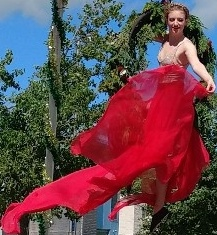

In [167]:
img_pil

In [168]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

In [169]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

## 预处理

In [170]:
img, rgb_img_float, input_tensor = get_image_from_path(img_path)

In [171]:
img.shape

(235, 217, 3)

In [172]:
input_tensor.shape

torch.Size([1, 3, 235, 217])

## 初始化DFF算法

In [173]:
classifier = model.classifier

In [174]:
dff = DeepFeatureFactorization(model=model, 
                               target_layer=model.conv_last, 
                               computation_on_concepts=classifier)

In [175]:
# concept个数（图块颜色个数）
n_components = 3

concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)

In [176]:
concepts.shape

(1280, 3)

## 图像中每个像素对应的concept热力图

In [177]:
# concept个数 x 高 x 宽
batch_explanations[0].shape

(3, 235, 217)

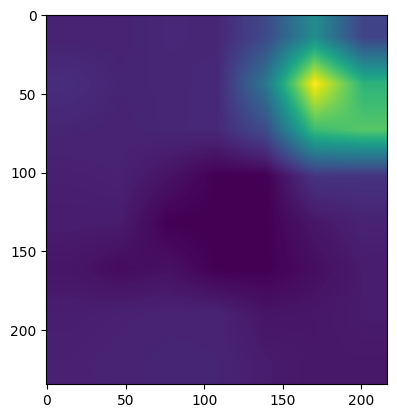

In [178]:
plt.imshow(batch_explanations[0][1])
plt.show()

## concept与类别的关系

In [179]:
concept_outputs.shape

(3, 8)

In [180]:
concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()    

In [181]:
concept_outputs.shape
print(concept_outputs)

[[0.11661784 0.11327872 0.09430359 0.1291233  0.06542312 0.25460988
  0.16079018 0.06585349]
 [0.15083687 0.14507417 0.05102453 0.15858299 0.18197434 0.12878333
  0.10885955 0.07486424]
 [0.09124053 0.07344968 0.07019464 0.09999926 0.13162906 0.20856556
  0.16198407 0.16293715]]


## 每个concept展示前top_k个类别

In [182]:
# 每个概念展示几个类别
top_k = 2

In [183]:
concept_label_strings = create_labels(concept_outputs, top_k=top_k)

In [184]:
concept_label_strings

['plant:0.25\nstructure:0.16',
 'person:0.18\nmater:0.16',
 'plant:0.21\nvertebrate:0.16']

## 生成可视化效果

In [185]:
from pytorch_grad_cam.utils.image import show_factorization_on_image
visualization = show_factorization_on_image(rgb_img_float, 
                                            batch_explanations[0],
                                            image_weight=0.3, # 原始图像透明度
                                            concept_labels=concept_label_strings)

In [186]:
result = np.hstack((img, visualization))

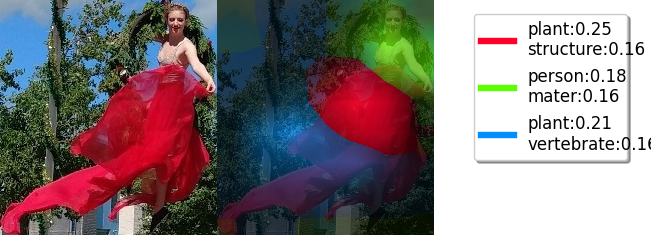

In [187]:
Image.fromarray(result)

## 封装函数

In [188]:
def dff_show(img_path='test_img/cat_dog.jpg', n_components=4, top_k=2, hstack=False):
    img, rgb_img_float, input_tensor = get_image_from_path(img_path)
    dff = DeepFeatureFactorization(model=model, 
                                   target_layer=model.conv_last, 
                                   computation_on_concepts=classifier)
    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()
    concept_label_strings = create_labels(concept_outputs, top_k=top_k)
    visualization = show_factorization_on_image(rgb_img_float, 
                                                batch_explanations[0],
                                                image_weight=0.3, # 原始图像透明度
                                                concept_labels=concept_label_strings)
    if hstack:
        result = np.hstack((img, visualization))
    else:
        result = visualization
    display(Image.fromarray(result))

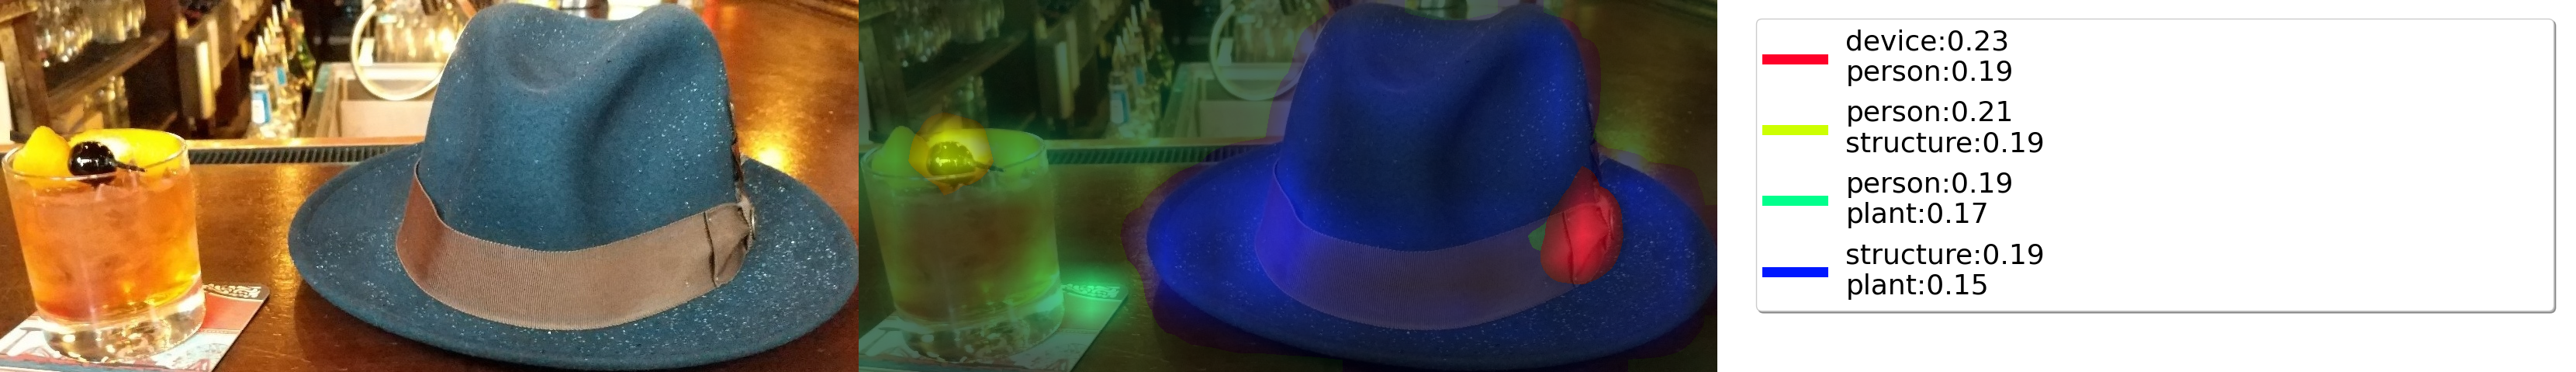

In [189]:
dff_show(img_path=img_paths_final[255], hstack=True)